Saved air_stability_final as ('png', 'pdf')


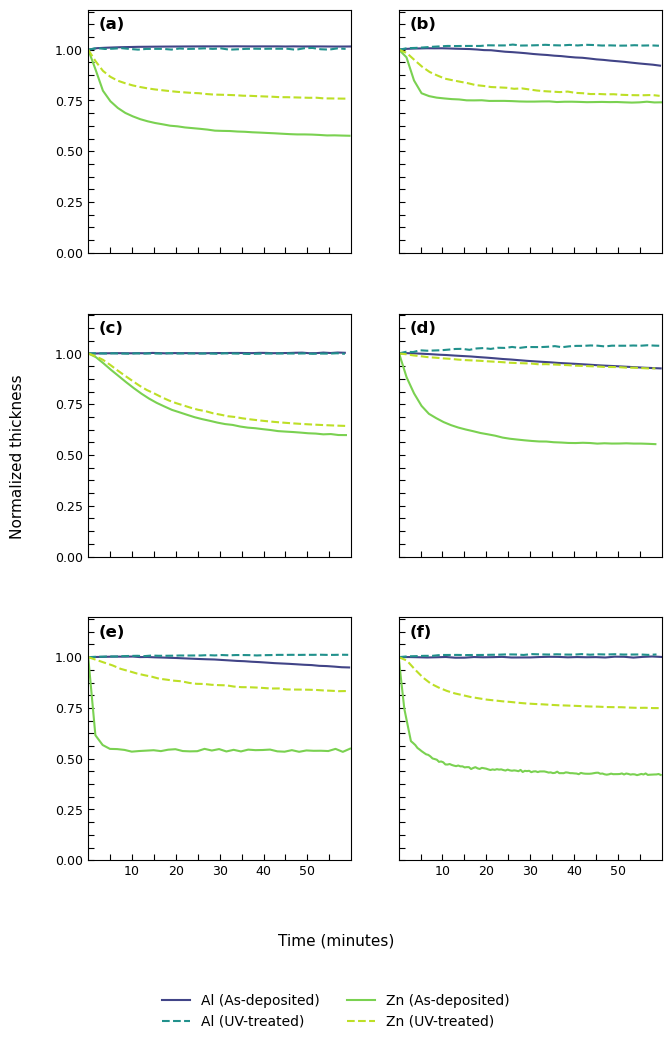

In [4]:
# %% [markdown]
"""
# Final Air Stability Figure
Creates a polished six-panel figure showing normalized thickness decay in air for Alucone and Zincone hybrid films (as-deposited and UV-treated).
"""

# %% [Setup]
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

from shared.utils.config import organics, inorganics, colors
from shared.utils.helpers import create_figure, save_figure
from shared.scripts.data_loading import load_excel

# Section-specific settings
time_limit_minutes = 60
sampling_rate = 10

# Excel file paths (local to this section)
excel_map = {
    'Al': '../data/raw/alucone.xlsx',
    'Zn': '../data/raw/zincone.xlsx'
}

# %% [Data Loading and Preprocessing]

def preprocess_series(x, y, limit_minutes=60, step=10):
    """
    Normalize thickness and downsample.
    """
    y_norm = y / y.iloc[0] if y.iloc[0] != 0 else y
    mask = x <= limit_minutes
    return (
        x[mask].iloc[::step].reset_index(drop=True),
        y_norm[mask].iloc[::step].reset_index(drop=True)
    )

# Load and preprocess data
data = {}
for metal, filepath in excel_map.items():
    df = load_excel(filepath)
    cols = df.columns.tolist()
    pairs = [(cols[i], cols[i+1]) for i in range(0, len(cols), 2) if i+1 < len(cols)]
    metal_dict = {}
    for xcol, ycol in pairs:
        uv_flag = ycol.endswith(' UV')
        org = ycol.replace(' UV', '')
        if org in organics:
            x_proc, y_proc = preprocess_series(df[xcol], df[ycol], time_limit_minutes, sampling_rate)
            metal_dict.setdefault(org, {})[uv_flag] = (x_proc, y_proc)
    data[metal] = metal_dict

# Calculate global axis limits
all_x = [arr[0].values for md in data.values() for series in md.values() for arr in series.values()]
all_y = [arr[1].values for md in data.values() for series in md.values() for arr in series.values()]
x_min, x_max = np.min(np.concatenate(all_x)), np.max(np.concatenate(all_x))
y_min, y_max = 0, np.max(np.concatenate(all_y)) * 1.15

# %% [Plotting]

# Create figure
fig, axes = create_figure(rows=3, cols=2, width_cm=18, aspect_ratio=2/3, sharex=True, sharey=True)
panel_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']

# Plot loop
for idx, org in enumerate(organics):
    ax = axes[idx]
    for metal in inorganics:
        series = data.get(metal, {}).get(org, {})
        for uv_flag, linestyle in [(False, '-'), (True, '--')]:
            if uv_flag in series:
                x, y = series[uv_flag]
                label = f"{metal} ({'UV-treated' if uv_flag else 'As-deposited'})"
                ax.plot(
                    x, y,
                    color=colors[(metal, uv_flag)],
                    linestyle=linestyle,
                    linewidth=1.5,
                    label=label if idx == 0 else None
                )
    # Panel label
    ax.text(0.04, 0.97, panel_labels[idx],
            transform=ax.transAxes,
            fontsize=12, fontweight='bold',
            va='top', ha='left')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.xaxis.set_major_locator(MultipleLocator(10))
    ax.xaxis.set_minor_locator(MultipleLocator(5))
    ax.yaxis.set_major_locator(MultipleLocator(0.25))
    ax.yaxis.set_minor_locator(AutoMinorLocator(4))
    ax.tick_params(direction='in', which='both', length=4, width=0.8, labelsize=9)
    for spine in ax.spines.values():
        spine.set_linewidth(0.8)

# Hide unused subplots (if fewer than 6 organics, unlikely here)
for i in range(len(organics), len(axes)):
    axes[i].axis('off')

# Unified legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    ncol=2, fontsize=10,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.05),
    frameon=False
)

# Global axis labels
fig.text(0.5, 0.04, 'Time (minutes)', ha='center', fontsize=11)
fig.text(0.04, 0.5, 'Normalized thickness', va='center', rotation='vertical', fontsize=11)

# Layout adjustment
fig.subplots_adjust(
    left=0.15, right=0.96,
    bottom=0.12, top=0.92,
    wspace=0.18, hspace=0.25
)

# Save figure
save_figure(fig, filename="air_stability_final")
plt.show()
